## Feature importance and outlier detection, oh my

In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
import random
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression,LinearRegression
import seaborn as sns

from scipy.optimize import minimize

import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

from sklearn.preprocessing import StandardScaler

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

s=100
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18,8)


## Feature Importance
When working on some data science problem, we might want to understand what are our most important features - note that the importance of the features might also depend on the model itself which is used, for example a feature might not be important in a linear model without interactions, but it can be important when using a model which considers interactions between features.

But why would we care about it, instead of just throwing all the features in into the model and hoping for the best?
* Interpretability - for example, we might be working on some business problem, and we want to understand and communicate to other people the impact of the various features.

* Feature Selection - finding irrelevant features, removing them might help by:
    - Improving model performance
    - Faster model

#### Regression Coefficients
Let's consider a linear regression model:


$ Y=\beta_0 + \beta_1 X_1 + \beta_2  X_2 $  

On a very basic level, we can interpret a coefficient $\beta_i$ as the effect of $X_i$ when the other variables are held fixed.

Therefore, a higher coefficient corresponding to some feature indicates that such a feature is important.

Note that to compare fairly between the various features we should scale the data, as discussed in lecture 2.

In addition, if we want to make such statements in a more "statistically safe" manner, we should consider the sample size and more statistical properties of the estimation, which we won't delve into here.


In [2]:
path = 'diabetes.csv'
cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv(path, header=None, names=cols).drop([0])
df = df.rename(columns={"label": "sick"})

In [3]:

X = df.drop(columns='sick')
y = df['sick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [4]:
lm = LogisticRegression(random_state=1)
lm.fit(X_train, y_train)

LogisticRegression(random_state=1)

Text(0.5, 1.0, 'Logistic Regression coefficients')

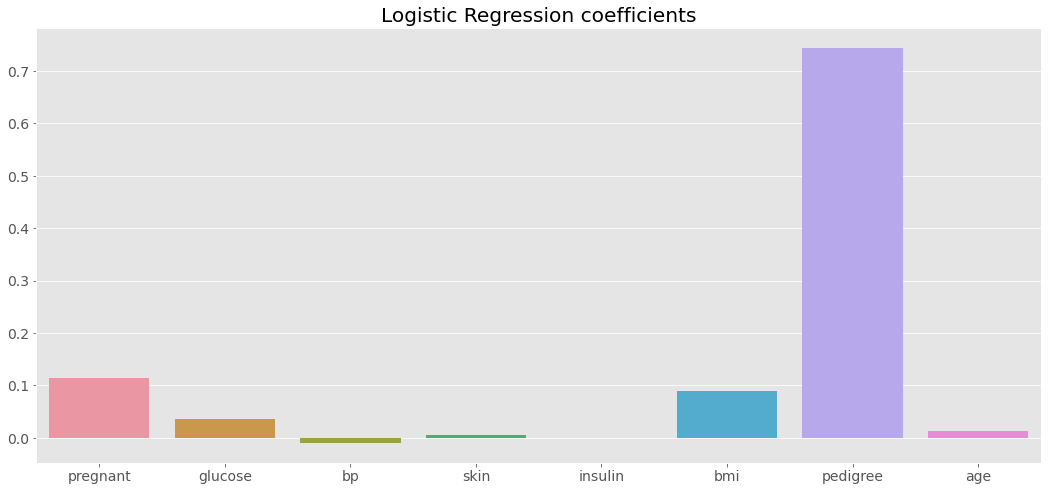

In [5]:
sns.barplot(x=list(X.columns),y=lm.coef_.flatten())

plt.title("Logistic Regression coefficients")

There are a few things to note here:
 - Note that, while very small in magnitude, the bp variable has a negative coefficients- this can be (roughly) interpreted as "when all other features are kept constant, an increase in bp leads to a higher chance for a 0 label".
 - Thus, we can try and interpret feature importances using each feature's coefficient magnitude (absolute value).
 - As we've discussed in a previous lecture, this value is very much dependent on the data's scale. For example:

In [6]:
from sklearn.preprocessing import StandardScaler
scaley= StandardScaler()
lm2 = LogisticRegression(random_state=1)
lm2.fit(scaley.fit_transform(X_train), y_train)

LogisticRegression(random_state=1)

<AxesSubplot: >

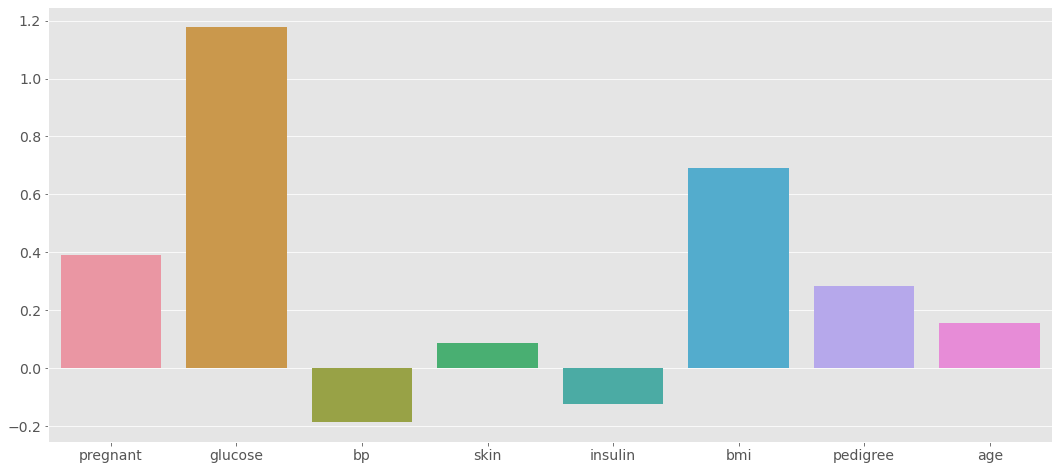

In [7]:
sns.barplot(x=list(X.columns),y=lm2.coef_.flatten())

We got a completely different result!

Another important value to consider is the regularization factor. Previously in this course (and IML), we've discussed mode hyperparameters and lightly touch the concept of regularization. As a reminder, regularization is a general name for method that allow us to control overfitting in our models and allow us to generalize better. In the case of a ilinear model, you're probably familiar with at least L1 or L2 regularization- also called Lasso and Ridge - both of which penalize the magnitude of coefficients and allowing more 'important' features to be prioritized, helping us avoid having to use many featuers when only some exist.

This obviously affects the coefficients. 

An important thing to note is that the sklearn implementation of Logistic Regression utilizes L2 regularization *by default* using the hyperparameter C- which is the inverse of the regularization parameter (i.e, smaller values == stronger regularization). Tuning it may alter coefficients heavily:

<AxesSubplot: >

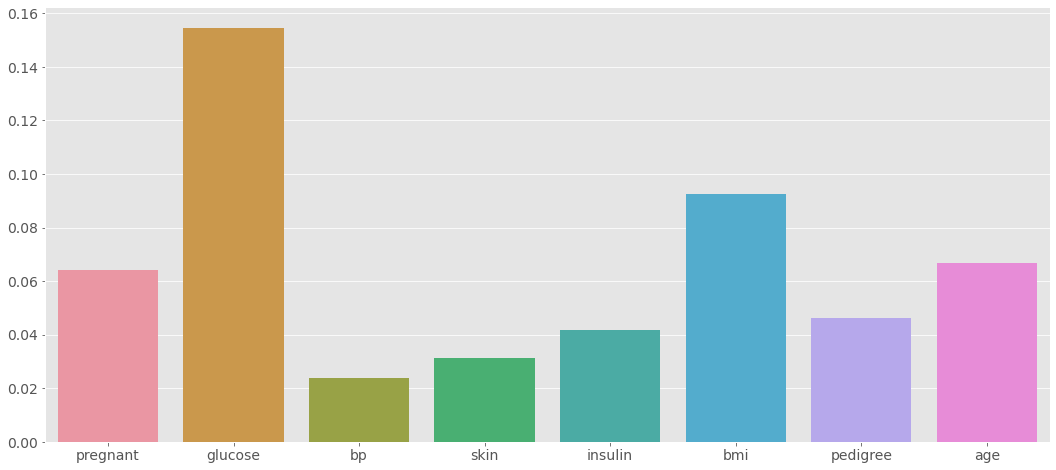

In [8]:
from sklearn.preprocessing import StandardScaler
scaley= StandardScaler()
lm3 = LogisticRegression(random_state=1,C=.0015)
lm3.fit(scaley.fit_transform(X_train), y_train)
sns.barplot(x=list(X.columns),y=lm3.coef_.flatten())

#### Feature Importance in Tree Based Models

First, we will talk about a metric which is used for training decision trees - Gini impurity, a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset:

## $ \sum _{i=1}^{C} P(i) \cdot (1 - P(i))$


We can estimate the feature importance in tree based models with a a technique called mean decrease in impurity, basically it works like this:

For every feature in the data, go over every tree in the ensemble, and for every node that uses the feature compute the improvment in the purity by computing it before and after the split, weight this node by the proportion of samples that traverse it, sum over these nodes in the tree, and average over the trees in the ensemble to get the final feature importance. 
(some of these details may vary across implementations)


![alt text](https://miro.medium.com/max/1838/1*Udn4H4-JgG_Ga8NWaV3WNQ.png "Title")


Let's see this with a random forest model:

In [9]:
path = 'diabetes.csv'
cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv(path, header=None, names=cols).drop([0])
df = df.rename(columns={"label": "sick"})

df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,sick
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1


In [10]:
X = df.drop(columns='sick')
y = df['sick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [11]:
rf = RandomForestClassifier(random_state=6)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=6)

In [12]:
feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])

In [13]:
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])

<AxesSubplot: >

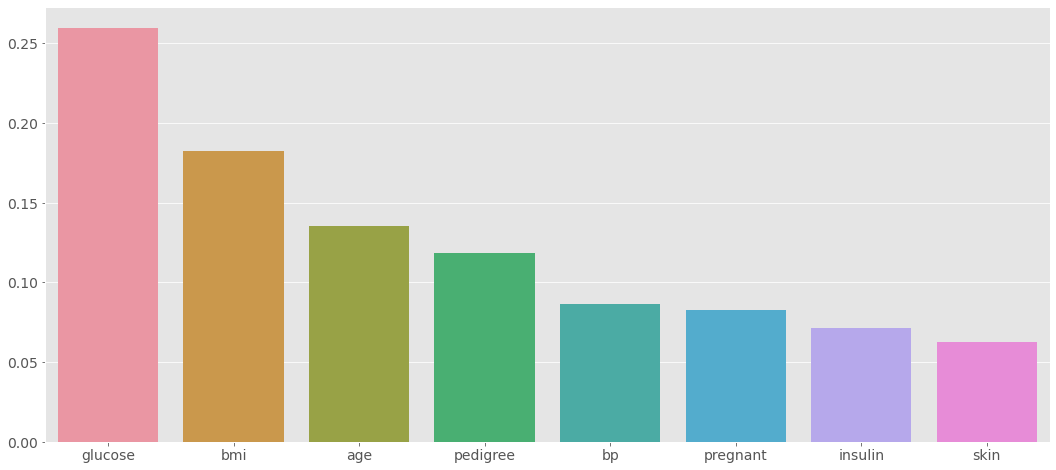

In [14]:
sns.barplot(x=columns, y=importances)

In [15]:
print("Balanced accuracy = {} ".format(balanced_accuracy_score(y_test, rf.predict(X_test))))

Balanced accuracy = 0.7098538045355128 


In [16]:
cols_to_remove = ['skin']
rf_no_skin = RandomForestClassifier(random_state=6)
rf_no_skin.fit(X_train.drop(columns=cols_to_remove), y_train)

RandomForestClassifier(random_state=6)

In [17]:
print("Balanced accuracy without the skin feature = {} ".format(balanced_accuracy_score(y_test, rf_no_skin.predict(X_test.drop(columns=cols_to_remove)))))

Balanced accuracy without the skin feature = 0.7014504431909749 


The balanced accuracy on the test set improved a little when removing the skin feature.

Note that this method might somtimes be misleading - this method favors features with higher cardinality, as they might have more splits in the trees by chance.

#### Permutation feature importance
Unlike the previous method, this one works for any type of model and is not biased.

It works by as follows:
* After training the model on the training set, save its performance(possibly on the validation set) according to some evaluation metric.
* Shuffle the values of a feature, and evaluate the model again on this metric, repeat according to the number of repetitions that we specify.
* Calculate the differences between scores on the original data and the permuted data. The larger the differnce - the more important is the feature.

The rationale is that if a feature is not important, than permuting its values won't effect the prediction very much.


![alt text](https://i.imgur.com/h17tMUU.png "Title")


In [18]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=1)

In [19]:
feature_importances = sorted(list(zip(X_train.columns, result['importances_mean'])), key=lambda x: -x[1])

<AxesSubplot: >

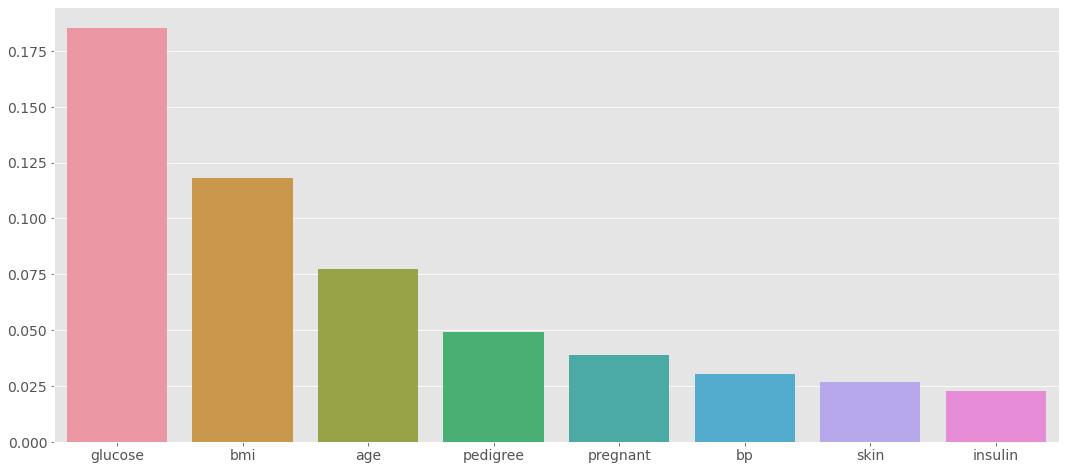

In [20]:
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)

We get similar results to the built-in random forest feature importance.

The con of this method is that it might be slow because of the shuffling.

### SHAP values



SHAP values originate from game theory. As such, we'll start by formulating a game to simulate. Given a sample and a model, the 'game' would be the reproduction of the model's result on the sample. The players are each individual feature. SHAP values attempt to quantify the contribution each individual feature yields for the prediction of each data point.

We begin by training a model for each subset of features of our overall feature sets (starting with single feature models and working our way up), and measuring the effect of adding each feature to each model. Each difference of prediction is called a marginal contribution. For example, if we used a lienar model with just the intercept, and added the "age" feature, the marginal contribution for this model and sample would be the difference between predicting using only the itnercept and predicting using both the itercept and the age feature.

We then weigh the marginal contributions by maintainig that the sum of weights should be both consistent between each model complexity level (i.e, the sum of 1-feature model weights is equal to the sum of 2-feature model weights) and the weights of models using the same amount of features have the same weights.

This requires an extremely large amount of models, which is why libraries (like the one used below) perform approximations of these metrics.

, and with them we can understand the contribution of the individual features to a particular prediction of the model. It works for models of varying complexity.


In [21]:
x1 = X_train.iloc[0].values.reshape(1, -1)
X_train.iloc[0]

pregnant        2
glucose       174
bp             88
skin           37
insulin       120
bmi          44.5
pedigree    0.646
age            24
Name: 733, dtype: object

In [22]:
rf.predict_proba(x1)

array([[0.06, 0.94]])

In [23]:

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x1)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x1, feature_names=X_train.columns)

* The baseline value is the average prediction of the model over the whole dataset, here - 0.359
* The prediction is 0.78
* The sum of the shap values over all the features = prediction - baseline
* The SHAP value of a feature is visualized by the bar size
* Blue bars pull the prediction down, while the red bars pull it up.

Now, visualizing the SHAP values of a "sick" person:

In [24]:
x2 = X_train.iloc[20].values.reshape(1, -1)
X_train.iloc[20]

pregnant       3
glucose      115
bp            66
skin          39
insulin      140
bmi         38.1
pedigree    0.15
age           28
Name: 319, dtype: object

In [25]:
rf.predict_proba(x2)

array([[0.93, 0.07]])

In [26]:

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x2)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x2, feature_names=X_train.columns)

When trying the get the overall picture, we can use some useful built-in options like the beeswarm plot- features are ordered by their precieved importance, and their SHAP values are displayed.

In [27]:
from xgboost import XGBClassifier
xgb =XGBClassifier()
xgb.fit(X_train.astype(float), y_train.astype(float))

[14:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
explainer_xgb = shap.Explainer(xgb, shap.utils.sample(X, 100).astype(float))


In [29]:
shap_vals = explainer_xgb(X_train.astype(float))


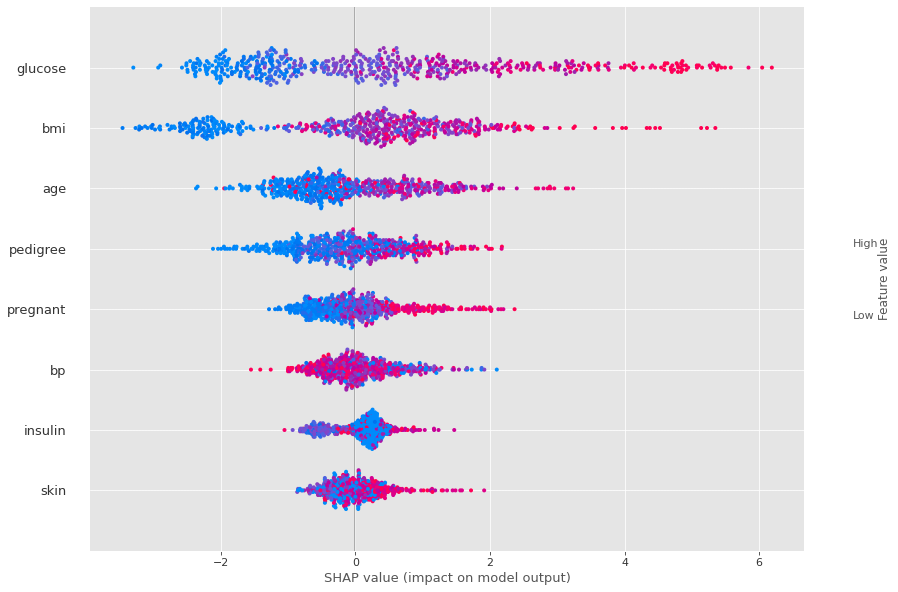

In [30]:
shap.plots.beeswarm(shap_vals,plot_size=(16,10))


### Partial Dependence Plots(PDP)
PDP plots are a a visualization tool which we can use to understand how a feature effects the predictions of the model.

In [31]:
from sklearn.datasets import load_diabetes


data = load_diabetes(as_frame=True)
df = data.frame
X = df.drop(columns=['target'])
y = df['target']
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
gb.fit(X, y)

GradientBoostingRegressor()

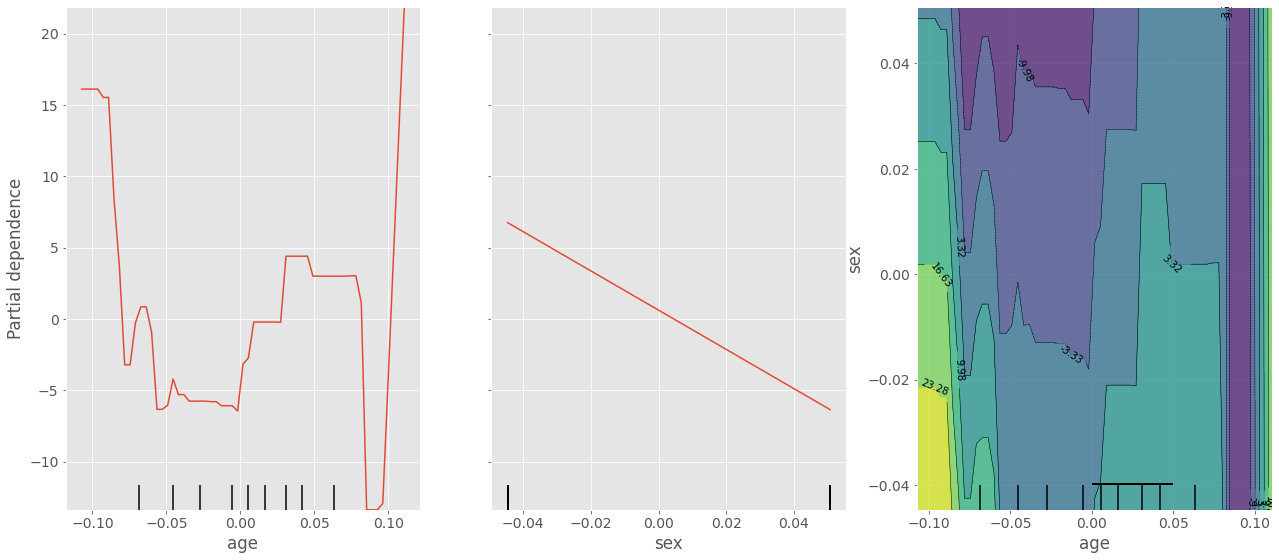

In [33]:
PartialDependenceDisplay.from_estimator(gb, X,[0,1,(0,1)])
plt.tight_layout()

How PDPS are created:
 for a chosen feature, fix its value in all of the data points, calculate the prediction for each data point, average them, and plot the result, then go for the next value, and so forth.

Partial dependence plots allow us to more closely inspect the dependence (surprisignly) of features' value ranges on the resulting prediction. For example, we see that some ranges of values for the age column have a very strong linear effect, while some have very small effects on the prediciton themselves. 

We can also observe the effect created by any pair of features to better understand their interaction and mutual effects.

## Detecting hard to predict and influential samples

Now that we've talked about the importance of features, it's time to talk about the importance of specific samples.

Let's review an earlier examples as motivation:

In [34]:
f = lambda X,w: X.dot(w)


def loss(w, X, y):
    mae =(np.abs(y - f(X, w))).mean()
    return mae


sigma = 1
n = 50
x = np.random.uniform(-2, 7, n) 

y_lm = -5 + 3*x + np.random.normal(scale=sigma ,size=n)

idx = [10, 30, 45]
y_lm[idx] = y_lm[idx] + 40

Text(0, 0.5, 'y')

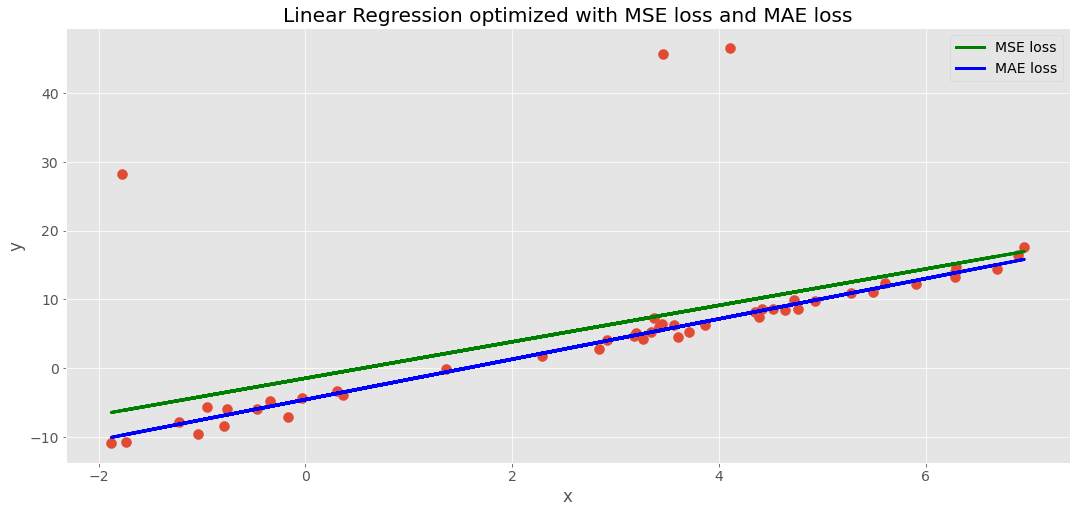

In [35]:

X_c = np.hstack((np.ones(x.size).reshape(-1,1), x.reshape(-1,1)))
opt = minimize(loss, np.zeros(2), args=(X_c,y_lm))
w_robust = opt.x
preds_robust = f(X_c, w_robust)
reg = LinearRegression().fit(x.reshape(-1,1), y_lm)
preds_ols = reg.predict(x.reshape(-1,1))
plt.scatter(x=x, y=y_lm, s=s)
l1 = plt.plot(x, preds_ols, linewidth=3, color='green', label="MSE loss")
l2 = plt.plot(x, preds_robust, linewidth=3, color='blue', label="MAE loss")
leg = plt.legend()

plt.title("Linear Regression optimized with MSE loss and MAE loss")
plt.xlabel("x")
plt.ylabel("y")

We we get here is, as we remember, two linear models optimized for different loss functions. Instead of discussing their outlier-ness, we'll use the outlying data points as examples for "important" or "influential" data points.

The main issue being that, probably, the effect of "dropping" these points would be much more significant on model calculation than the effect  of dropping any three of the original points. It's also pretty clear that our error (or residual) for these points will be much larger than for any of the 'concensus' points.

Ideally, we'd like to be able to identify such points and treat them- whether by trying to drop them and "see what happens", or identifying different patterns in our features that could lead us to create a more verbose feature set.

First, we'll talk about linear regression as some basic motivation.

Sadly, sklearn falls short when it comes to more 'classical' statistical processes. We'll be using a library called statsmodels. Those of you who are familiar with R should feel at home.

We'll start by fitting a linear model:

In [36]:
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.stats.tests.test_influence


In [37]:
res = GLM(y_lm,x.reshape(-1,1)).fit()

In [38]:
print(res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       49
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          89.547
Method:                          IRLS   Log-Likelihood:                -182.81
Date:                Wed, 16 Nov 2022   Deviance:                       4387.8
Time:                        14:06:34   Pearson chi2:                 4.39e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3660      0.343      6.902      0.0

And now, for influence measures.

While many different influence measures exist, we will focus on the dffit and dfbeta measures, whoch measure the effect of dropping a single point on the same point's standardized predicted result and on each coefficient.

In [39]:
res.get_influence(observed=False).summary_frame().sort_values("dffits_internal").loc[idx]


,dfb_x1,cooks_d,standard_resid,hat_diag,dffits_internal
10,0.592948,0.351587,3.942500,0.022120,0.592948
30,-0.221611,0.049112,3.438662,0.004136,0.221611
45,0.503490,0.253503,3.991231,0.015664,0.503490


In [40]:
res.get_influence(observed=False).summary_frame().sort_values("dfb_x1").loc[idx]


,dfb_x1,cooks_d,standard_resid,hat_diag,dffits_internal
10,0.592948,0.351587,3.942500,0.022120,0.592948
30,-0.221611,0.049112,3.438662,0.004136,0.221611
45,0.503490,0.253503,3.991231,0.015664,0.503490


(array([47.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.00060256, 0.05983711, 0.11907166, 0.17830621, 0.23754076,
        0.29677531, 0.35600986, 0.41524442, 0.47447897, 0.53371352,
        0.59294807]),
 <BarContainer object of 10 artists>)

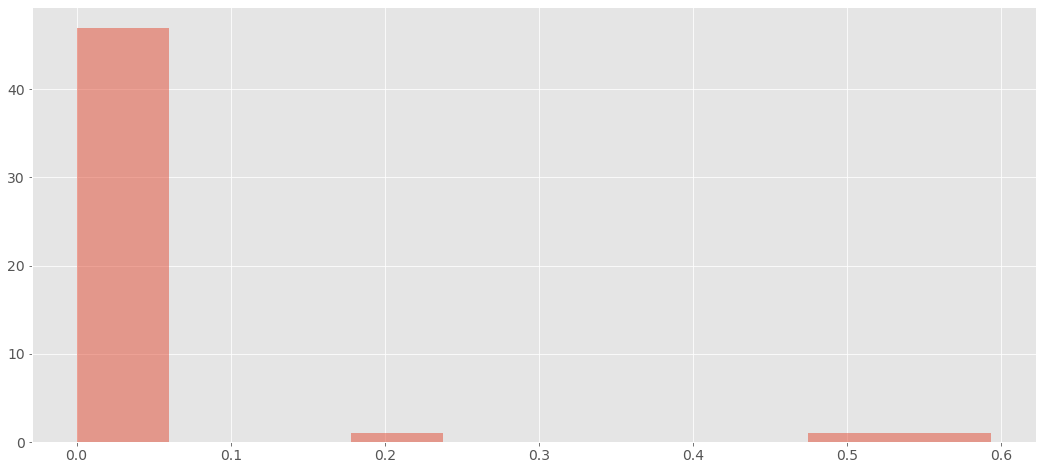

In [41]:
plt.hist(res.get_influence(observed=False).summary_frame()['dffits_internal'].abs(),alpha=.5)

This is rather fine for linear models- but what about tree-based models?

Try and think of a way to differentiate and point out difficult data points.


In essence, we want to avoid high decision variability. If we find a point we're 'not certain' about- this point could be desginated as a poblematic, or difficult, data point. In practice, if working with an ensemble for example, we can use the distribution of prediction standard deviations to try and identify data points which we have trouble predicting for.

In [42]:
rf = RandomForestRegressor(30)
rf.fit(X, y)

RandomForestRegressor(n_estimators=30)

<AxesSubplot: >

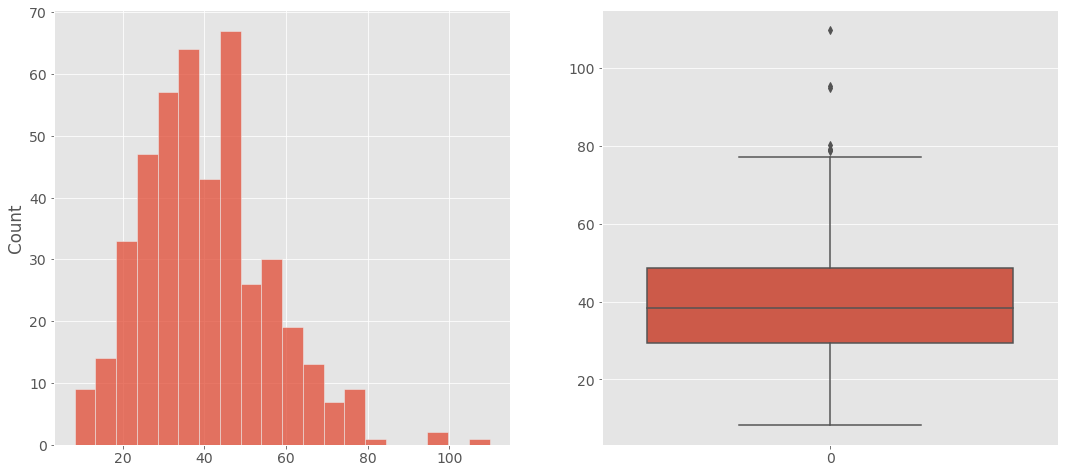

In [43]:
fig,axes = plt.subplots(1,2)
sns.histplot(np.vstack([i.predict(X) for i in rf.estimators_]).std(axis=0),ax=axes[0])
sns.boxplot(np.vstack([i.predict(X) for i in rf.estimators_]).std(axis=0),ax=axes[1])

This leads us to talk about one more topic- Outlier detection.

The stray samples in the simple regression are good, basic examples of outlier samples- data points who are out-of-distribution and could potentially be either noise or rate cases. We've seen examples of visually detecting outliers earlier- as some unclean data can be construed as outliers. 



![title](./outliers.png)

It's hard to really talk about outliers confidently for the exact same reason that talking about data cleaning is hard- we have to _find_ them. They might be anything from recording and survey errors, out of distribution samples or simply true outliers.

Sometimes, finding the outliers is our goal altogether- in cases of fraud detection, for example. The overwhelmingly larger amount of legitimate credit card transactions of a person will hopefully "behave" differently than the rare fraudulent transactions, which we'd like to detect.

As for methods of finding outlier- they can be as easy as looking at a box plot- as we remember for week 1, the 'dots' outside the general form of the boxplots are dots considered as 'outliers'.
This allows for a novel and rather basic anomaly detection method, using the Z-score for each sample. 

A Z-score is a measure of adressing how far from the mean value is any point, usually calculated in units of standard deviations. We can use the sum of z scores (or their mean) as a measure of how generally far is some points from the mean.

Other than this method, we've already seen a way to find outliers. The DBSCAN algorithm we discussed in week 2 classifies outliers using the data points' density.

Another example for an anomaly detection algorithm is (how surprsing) a tree based method called an Isolation Forest. Simply put, using the decision tree's partitioning mechanism, we create a forest of trees whose partitions are done on a random feature with a random value in the feature's range, the idea being that anomalous examples will be split away more quickly.

In [44]:
cols = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df = pd.read_csv(path, header=None, names=cols).drop([0])
df = df.rename(columns={"label": "sick"})
X = df.drop(columns='sick')
y = df['sick']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [45]:
isf = IsolationForest()


In [46]:
isf.fit(X_train)

IsolationForest()

In [47]:
pd.Series(isf.predict(X_train)).value_counts()

 1    498
-1     78
dtype: int64